# Predictive Model

This final notebook is assoicated with the __Predictive Model__ section of the report.

## Packages
Importing all necessary packages to run the notebook

In [136]:
# file manipualtion
from pathlib import Path
import numpy as np
import pandas as pd
import pickle

# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif

# balancing dataset
from imblearn.over_sampling import SMOTE

# stats
from scipy.stats import pearsonr

# models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier

# visualistaion
import matplotlib.pyplot as plt
import seaborn as sns

# warning supression
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

## Directory navigation and creation
Creating pathlib.Path objects for cross-platform navigation and loading the three datasets into pandas DataFrame objects

**Note:** here we import the cleaned accidents.pkl file

In [24]:
# creating Path object for current working directory
cwd = Path('./')
root = cwd.resolve().parent
# creating Path object for additional data directory
additional_data_dir = root / 'additional_data'
# create new directory for additional data
Path(additional_data_dir).mkdir(exist_ok=True)

# creating Path object for plots directroy
plots_dir = root / 'plots'
# create new directory for plots
Path(plots_dir).mkdir(exist_ok=True)

# defining the directory to original data
data_dir = root / 'data'
additional_directory = root / 'additional_data'

# list the .csv files for the project
for file in data_dir.glob('*.csv'):
    print(file)
    
# reading in .csv files to dataframes
vehicles = pd.read_csv(data_dir / 'vehicles2019.csv', dtype={'Accident_Index': str})
casualties = pd.read_csv(data_dir / 'casualties2019.csv', dtype={'Accident_Index': str})
# cleaned accidents DataFrame
accidents = pd.read_pickle(additional_data_dir / 'accidents_cleaned.pkl')

# convert column names to lowercase for ease of indexing
def lower_columns(df):
    """
    Defintion:
        convert column names to lower case
    """
    df.columns = map(str.lower, df.columns)
    
# converting all column names to lower case
lower_columns(vehicles)
lower_columns(casualties)

accidents.head(5)

/Volumes/GoogleDrive/My Drive/Dev/TrafficAccidents/data/accidents2019.csv
/Volumes/GoogleDrive/My Drive/Dev/TrafficAccidents/data/casualties2019.csv
/Volumes/GoogleDrive/My Drive/Dev/TrafficAccidents/data/vehicles2019.csv


,accident_index,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,local_authority_(district),local_authority_(highway),...,lsoa_of_accident_location,district,converted_date,converted_time,sunrise,sunset,day_length,datetime,decimal_time,day_of_year
0,2019010128300,-0.153842,51.508057,1,3,2,3,2,1,E09000033,...,E01004762,westminster,2019-02-18,17:50:00,0 days 07:10:00,0 days 17:19:00,10:09:00,2019-02-18 17:50:00,17.833333,49
1,2019010164251,-0.141154,51.502191,1,3,1,2,2,1,E09000033,...,E01004736,westminster,2019-02-18,18:50:00,0 days 07:10:00,0 days 17:19:00,10:09:00,2019-02-18 18:50:00,18.833333,49
2,2019010164259,-0.174097,51.527663,1,3,2,1,2,1,E09000033,...,E01004728,westminster,2019-02-18,23:00:00,0 days 07:10:00,0 days 17:19:00,10:09:00,2019-02-18 23:00:00,23.000000,49
3,2019010164414,-0.163973,51.515931,1,3,2,1,2,1,E09000033,...,E01004658,westminster,2019-02-18,02:00:00,0 days 07:10:00,0 days 17:19:00,10:09:00,2019-02-18 02:00:00,2.000000,49
4,2019010164107,-0.103521,51.464277,1,3,1,1,2,9,E09000022,...,E01003051,lambeth,2019-02-18,08:00:00,0 days 07:10:00,0 days 17:19:00,10:09:00,2019-02-18 08:00:00,8.000000,49


## Testing classification models

In [25]:
def get_models():
    """
    Create a dictionary of the classification models to
    be tested
    """
    models = {}
    models['decision_tree'] = DecisionTreeClassifier()
    models['knn'] = KNeighborsClassifier()
    models['bayes'] = MultinomialNB()
    models['rf'] = RandomForestClassifier()
    return models

models = get_models()

models

{'decision_tree': DecisionTreeClassifier(),
 'knn': KNeighborsClassifier(),
 'bayes': MultinomialNB(),
 'rf': RandomForestClassifier()}

In [26]:
# merge the three datasets
accidents = pd.merge(accidents, vehicles, on='accident_index', how='left')
accidents = pd.merge(accidents, casualties, on='accident_index', how='left')
accidents.columns

Index(['accident_index', 'longitude', 'latitude', 'police_force',
       'accident_severity', 'number_of_vehicles', 'number_of_casualties',
       'day_of_week', 'local_authority_(district)',
       'local_authority_(highway)', '1st_road_class', '1st_road_number',
       'road_type', 'speed_limit', 'junction_detail', 'junction_control',
       '2nd_road_class', '2nd_road_number',
       'pedestrian_crossing-human_control',
       'pedestrian_crossing-physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident',
       'lsoa_of_accident_location', 'district', 'converted_date',
       'converted_time', 'sunrise', 'sunset', 'day_length', 'datetime',
       'decimal_time', 'day_of_year', 'vehicle_reference_x', 'vehicle_type',
       'towing_and_articulation', 'vehicle_manoeuvre',
       'vehicle_location-restricted_lane

# Feature Selection

### Test for columns with many values less than 0

Any column with more than 10% of values being less than 0 is dropped.

In [27]:
# exclude columns with non-numerical data types
test = accidents.select_dtypes(exclude=['object', 'datetime64', 'timedelta64[ns]'])

ratios = ((test < 0).sum() / test.sum()).to_dict()

to_delete = []
for k, v in ratios.items():
    if v > 0.10:
        to_delete.append(k)

print(to_delete)

['junction_control', '2nd_road_class', 'special_conditions_at_site', 'carriageway_hazards', 'towing_and_articulation', 'vehicle_location-restricted_lane', 'skidding_and_overturning', 'hit_object_in_carriageway', 'vehicle_leaving_carriageway', 'hit_object_off_carriageway', 'propulsion_code', 'driver_home_area_type', 'casualty_home_area_type']


In [28]:
# manually determine data type of features
numeric = ['number_of_vehicles', 'number_of_casualties', 'age_of_driver',
           'engine_capacity_(cc)', 'age_of_vehicle', 'age_of_casualty']

binary = ['was_vehicle_left_hand_drive?', 'sex_of_driver', 'sex_of_casualty']

nominal = ['1st_road_class', 'road_type', 'junction_detail', 'light_conditions',
           'weather_conditions', 'road_surface_conditions',
           'urban_or_rural_area',
           'vehicle_type', 'vehicle_manoeuvre',
           'junction_location', 'journey_purpose_of_driver', 'casualty_type']

ordinal = ['speed_limit', 'day_of_week', 'day_of_year', 'age_band_of_driver', 'age_band_of_casualty']

target = 'accident_severity'

In [29]:
class FeatureSelection:

    def __init__(self, df, cat_features, numeric_features, target):
        self.df = df
        self.cat_features = cat_features
        self.numeric_features = numeric_features
        self.target = target

    def remove_negatives(self):
        """
        Remove rows with any negative values for features in
        the data members 'cat_features' and 'numeric_features'
        """
        features = self.numeric_features + self.cat_features
        filtered = self.df.filter(features + [self.target], axis=1)
        filtered = filtered[(filtered > 0).all(1)]
        return filtered

    def get_feature_scores(self, k='all'):
        """
        Return the 'KBest selected' columns and scores using
        ANOVA
        """
        filtered_dataset = self.remove_negatives()
        features = self.cat_features
        selector = SelectKBest(f_classif, k=k)
        selector.fit(filtered_dataset[features], filtered_dataset[self.target])

        cols = selector.get_support(indices=True)
        p_values = selector.pvalues_

        p_values = pd.Series(p_values, dtype='object')
        scores = -np.log10(selector.pvalues_)
        return cols, scores

    def plot_features(self):
        """
        Plot the scores determined from get_feature_scores
        """
        features, scores = self.get_feature_scores(k='all')
        print(features)
        plt.bar(range(len(features)), scores)
        plt.xticks(range(len(features)), features, rotation='vertical')
        plt.show()
    
    def get_new_X(self):
        """
        Get the transformed dataframe using only the columns
        from get_feature_scores
        """
        filtered_dataset = self.remove_negatives()
        kbest_cols, _ = self.get_feature_scores(k=12)
        target = self.target
        target_i = filtered_dataset.columns.get_loc(self.target)
        kbest_cols = np.append(kbest_cols, target_i)
        new_df = filtered_dataset.iloc[:, kbest_cols]
        
        return new_df

fs = FeatureSelection(accidents, nominal+ordinal+binary, numeric, target)

filtered = fs.get_new_X()

/var/folders/ym/67nh3yg92pl8g2wbm_vrs8_h0000gn/T/ipykernel_3981/444866100.py:33: RuntimeWarning: divide by zero encountered in log10
  scores = -np.log10(selector.pvalues_)


/var/folders/ym/67nh3yg92pl8g2wbm_vrs8_h0000gn/T/ipykernel_3981/444866100.py:33: RuntimeWarning: divide by zero encountered in log10
  scores = -np.log10(selector.pvalues_)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


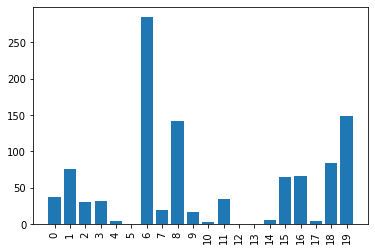

In [30]:
fs.plot_features()

In [31]:
filtered.columns

Index(['number_of_vehicles', 'number_of_casualties', 'age_of_driver',
       'engine_capacity_(cc)', '1st_road_class', 'junction_detail',
       'road_surface_conditions', 'urban_or_rural_area', 'junction_location',
       'journey_purpose_of_driver', 'speed_limit', 'day_of_week',
       'accident_severity'],
      dtype='object')

# Constructing the model

Determining the number of samples remaining:

In [32]:
print(f"Number of samples in filtered dataset: {filtered.shape[0]}")
print(f"Number of samples in the original dataset: {accidents.shape[0]}")
print(f"Proportion of samples remaining: {100 * filtered.shape[0] / accidents.shape[0]:.2f}%")

Number of samples in filtered dataset: 98654
Number of samples in the original dataset: 295579
Proportion of samples remaining: 33.38%


We see that the model is heavily imbalanced towards accident_severity label 3. 

Hence, SMOTE oversampling should be used to balance the training data for more accurate training.

In [33]:
filtered.accident_severity.value_counts()

3    78790
2    18501
1     1363
Name: accident_severity, dtype: int64

Splitting the data into a 3:1 train/test ratio

In [109]:
X_data = filtered.iloc[:, :-1]
y_data = filtered.iloc[:, -1]

# splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.25)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)

# data set shapes
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (51793, 12)
y_train shape: (51793,)
X_val shape: (22197, 12)
y_val shape: (22197,)
X_test shape: (24664, 12)
y_test shape: (24664,)


In [83]:
print("Shapes prior to over-sampling: \n")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

print("\n\nShapes after over-sampling: \n")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

Shapes prior to over-sampling: 

X_train shape: (51793, 12)
y_train shape: (51793,)


Shapes after over-sampling: 

X_train shape: (123996, 12)
y_train shape: (123996,)


In [84]:
print("Label ratio after over-sampling")
y_train.value_counts()

Label ratio after over-sampling


3    41332
2    41332
1    41332
Name: accident_severity, dtype: int64

#### Evaluate model

Here we use a repeated stratified k-fold cross-validation method, so that the training data is split into k folds with equal proportions per label. Each k-1 folds are evaluated using the final fold as validation, and the process is repeated three times, hence repeated stratified k-fold.

### Training all models in the models dictionary

In [85]:
def evaluate_model(model, X, y):
    """
    Evaluate the models using a repeated stratified
    k-fold with 10 splits and 3 repeats
    """
    cv = RepeatedStratifiedKFold(n_splits=10,
                                 n_repeats=3,
                                 random_state=1)
    scores = cross_val_score(model, X, y,
                             scoring='accuracy',
                             cv=cv,
                             n_jobs=-1,
                             error_score='raise')
    return scores

In [38]:
results, names, summary_results = [], [], []
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    summary_results.append({name: {'mean': np.mean(scores), 'std': np.std(scores)}})
    print(f"{name} {np.mean(scores):.4f}, {np.std(scores):.4f}")

decision_tree 0.8880, 0.0023
knn 0.8713, 0.0021
bayes 0.4056, 0.0038
rf 0.9262, 0.0021


A random forest model has reached the highest cross-validated score, reaching 92.62%

In [39]:
summary_stats = []
for i in results:
    summary_stats.append([i.mean(), i.std()])
    
    
summary_stats = pd.DataFrame(summary_stats).T
print(summary_stats)
summary_stats.columns = names
summary_stats.index = ['mean', 'std']

summary_stats

          0         1         2         3
0  0.888040  0.871338  0.405586  0.926242
1  0.002283  0.002116  0.003756  0.002074


,decision_tree,knn,bayes,rf
mean,0.888040,0.871338,0.405586,0.926242
std,0.002283,0.002116,0.003756,0.002074


In [40]:
results

[array([0.88977177, 0.8845807 , 0.8877367 , 0.88503156, 0.88452435,
        0.88649684, 0.89190712, 0.89038548, 0.8877367 , 0.89241434,
        0.88655959, 0.88722949, 0.88520063, 0.88480613, 0.88644049,
        0.89106177, 0.89021641, 0.88801849, 0.8877367 , 0.88925834,
        0.88864469, 0.8873422 , 0.88863841, 0.89072362, 0.89094905,
        0.88514427, 0.88801849, 0.89032913, 0.8853697 , 0.8889202 ]),
 array([0.86970978, 0.86947701, 0.87471821, 0.871055  , 0.87629621,
        0.86829351, 0.86998422, 0.87195672, 0.87133679, 0.87139315,
        0.87038602, 0.87308386, 0.86981515, 0.87004058, 0.87099865,
        0.87161858, 0.87156222, 0.87545086, 0.87082958, 0.87218215,
        0.87094956, 0.87545086, 0.86789901, 0.871844  , 0.87297115,
        0.86778629, 0.87308386, 0.86947701, 0.87099865, 0.86947701]),
 array([0.40445196, 0.41140667, 0.40137511, 0.41332281, 0.40498197,
        0.40825068, 0.40706718, 0.4008679 , 0.40148783, 0.40233318,
        0.40259228, 0.40622182, 0.39912083, 

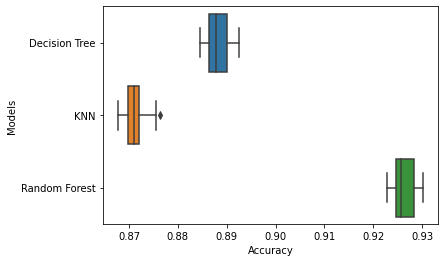

In [43]:
model_plot = sns.boxplot(data=results[:2] + results[3:], orient='h')
model_plot.yaxis.set_ticklabels(['Decision Tree', 'KNN',
                                 'Random Forest'])

model_plot.set_ylabel('Models')
model_plot.set_xlabel('Accuracy')

model_plot.figure.savefig(plots_dir / 'model_plot', bbox_inches='tight')

## Fitting the model

In [86]:
rf_model = models['rf']

rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [47]:
rf_model.score(X_test, y_test)

0.8420369769704833

## Saving model for later use

In [49]:
filename = 'prediction_model.pkl'
pickle.dump(stacked_model, open(filename, 'wb'))

Reopening model using pickle package.

In [147]:
with open('prediction_model.pkl', 'rb') as model:
    prediction_model = pickle.load(model)

## Comparing to the government model

In [ ]:
# load the government model into memory and store in a DataFrame
gov_model = pd.read_csv(additional_data_dir / 'cas_adjustment.csv')
# filter for the required features
gov_model = gov_model.filter(['accident_index', 'Adjusted_Serious', 'Adjusted_Slight'])

gov_model.head(5)

In [ ]:
# determine the probabilities of the classification model
probabilities = rf_model.predict_proba(X_val.drop('accident_index', axis=1))
class_labels = rf_model.classes_

# store in a DataFrame
probabilities = pd.DataFrame(probabilities, columns=class_labels)
probabilities.columns = ['fatal', 'serious', 'slight']

probabilities.head(5)

In [ ]:
# merge the probabilities with accident index
validation_aindex = X_val.accident_index
validation_data = validation_aindex.reset_index()

probabilities = validation_data.join(probabilities)

In [ ]:
final_df = probabilities.merge(gov_model, on='accident_index')
final_df

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(test2['serious'], test2['Adjusted_Serious'])

mean_squared_error(test2['slight'], test2['Adjusted_Slight'])